<a href="https://colab.research.google.com/github/csalguero10/InfoVisualization/blob/main/2022-2023/tutorials/dataviz_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data sense making

 1. Case study: the most studied artistic and historical periods

 2. Case study: the most studied artistic and historical periods over time

## Introduction

Usually, the first step should be to understand the added value of a given dataset, which requires the exploration to be performed **over the whole dataset**.

For the sake of this tutorial, we start from:

 * a given research question
 * a subset of the ARTchives graph.





In [1]:
!pip install rdflib

## 1. Case study: the most studied artistic and historical periods

We want to answer the following question:

```
What are the most studied artistic and historical periods according to ARTchives?
```

This question implies us to get some **statistics**, i.e. the distribution of artistic periods that are subjects of archival collections. This is the simplest **univariate analysis** possible on a dataset.

 * We consider a *categorial attribute* (the artistic period)
 * we look for the *numerical* distribution of the categorical attribute in the dataset (counting).

In order to answer this question we need to go through the seven stages of information visualization, namely:

 * acquire
 * parse
 * filter
 * mine
 * represent
 * refine
 * interact


### 1.1. Acquire and parse

We leverage the RDF dump of ARTchives data (`../resources/artchives.nq`). We parse the data by using the RDFLib python library.

In [2]:
# uncomment if colab
#!pip install rdflib
import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS

# bind the uncommon namespaces
wd = Namespace("http://www.wikidata.org/entity/") # remember that a prefix matches a URI until the last slash (or hashtag #)
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")

# create an empty Graph
g = rdflib.ConjunctiveGraph()

# parse a local RDF file by specifying the format
result = g.parse("https://raw.githubusercontent.com/marilenadaquino/information_visualization/main/2022-2023/resources/artchives.nq", format='nquads')

<ipython-input-2-829312af4d8f>:13: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  g = rdflib.ConjunctiveGraph()


#### 1.1.2  Filtering

In order to answer our research question we need to work only on a **subset of the graph**.

 * archival collections (individuals of the class `wd:Q9388534`)
 * subjects of the collections (`wd:Q9388534 > wdt:P921 > ?period`)
 * among the subjects, we have artistic and historical periods. Subject periods are also the range of the property `art:hasSubjectPeriod`.

We need to extract **for each artistic period**:

 * only one name associated to the artistic period (values of the property `art:hasSubjectPeriod / rdfs:label`)
 * all the collections linked to the artistic period (the domain of the property `art:hasSubjectPeriod`)
 * the counting of collections linked to the artistic period (either in SPARQL via `(COUNT(?collections) AS ?count)` or in python)

Step by step:

 * We query the graph, looking for periods and collections. Rather than iterating over triples, we use a sparql query.
 * We ask for collections `?coll`, their labels `?coll_label`, their associated artistic period `?period`, and their label `?period_label`.
 * We want only one label for each term (collection or period), hence we use `SAMPLE` to return 1 label.

In [3]:
# query the graph
query_periods = g.query(
    """SELECT (SAMPLE(?coll_label) AS ?coll) (SAMPLE(?label) AS ?period_label) # we want only one label!
    WHERE {
        ?coll <https://w3id.org/artchives/hasSubjectPeriod> ?period ;
              rdfs:label ?coll_label .
        ?period rdfs:label ?label .
    }
    GROUP BY ?period ?coll #when is there an operator, we need to specify
    ORDER BY ?period_label""")

# try the query on http://artchives.fondazionezeri.unibo.it/sparql to see the results!
for coll, period in query_periods:
  print(period.strip(), " - ", coll)

19th century  -  Archivio Luisa Vertova
neoclassicism  -  Fototeca Stefano Tumidei
neoclassicism  -  Archivio Luisa Vertova
14th century  -  Fototeca Fahy
modern art  -  Leo Steinberg research papers
18th century  -  Fototeca Stefano Tumidei
18th century  -  Luigi Salerno research papers
18th century  -  Archivio Luisa Vertova
Romanticism  -  Archivio Luisa Vertova
Cold War  -  Nachlass Ulrich Middeldorf
15th century  -  Fototeca Fahy
15th century  -  Fototeca Zeri
15th century  -  Fototeca Stefano Tumidei
15th century  -  John Pope-Hennessy papers
15th century  -  Fototeca Julian Kliemann
15th century  -  Gustav Ludwig-Vermächtnis
15th century  -  Nachlass Fritz Heinemann, Notizen zur venezianischen Malerei
15th century  -  Archivio Luisa Vertova
17th century  -  Fototeca Zeri
17th century  -  Fototeca Stefano Tumidei
17th century  -  Julius S. Held papers
17th century  -  Nachlass Wolfgang Lotz
17th century  -  Fototeca Julian Kliemann
17th century  -  Nachlass Fritz Heinemann, Notiz

### 1.2 Mine data

In order to use some popular python library for data mining and visualization we must transform data in **tabular form**.
We prepare a table (a .csv file) with two columns (`collection`, `period_label`) and we store results of the query there.

In our case, we want to plot the distribution of periods in a **bar chart**. Therefore we filter graph to get data about collections and subject periods, and we create a table wherein each row includes (1) a collection and (2) an artistic period.

In [4]:
# import csv built-in library
import csv

# prepare the csv file
with open('periods_count.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['collection', 'period_label'])

    # access the list of tuples of the query results
    for res in query_periods:
        # write in the csv
        my_writer.writerow([res['coll'], res['period_label'].strip()])



We introduce now **Pandas**, a Python library for **data analysis**.

Pandas requires us to parse data (from csv or json) in a new data structure called data frame (similar to a table) so that we can use some useful methods for the analysis and visualization.

In [5]:
# pandas
import pandas as pd

# parse the csv into a dataframe
df = pd.read_csv("periods_count.csv")
# print the first 15 rows
df.head(15)

,collection,period_label
0,Archivio Luisa Vertova,19th century
1,Fototeca Stefano Tumidei,neoclassicism
2,Archivio Luisa Vertova,neoclassicism
3,Fototeca Fahy,14th century
4,Leo Steinberg research papers,modern art
5,Fototeca Stefano Tumidei,18th century
6,Luigi Salerno research papers,18th century
7,Archivio Luisa Vertova,18th century
8,Archivio Luisa Vertova,Romanticism
9,Nachlass Ulrich Middeldorf,Cold War


### 1.3 Represent: Profiling and exploration, plotting data

A useful library is **pandas_profiling** that generates reports from a pandas dataframe, including basic statistics on the datasets and a few exploratory visualizations. This is very useful when you are working on big tables with many columns and rows.

In [6]:
# uncomment and restart the kernel if colab
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import pandas_profiling as pp
pp.ProfileReport(df)

<ipython-input-6-b355ff71d1d7>:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

To plot our data with Python in Jupyter we have plenty of libraries that support us. In this tutorial we use **seaborn**, a library for plotting data organised in data frames. See the [online documentation](https://seaborn.pydata.org/) with plenty of tutorials.

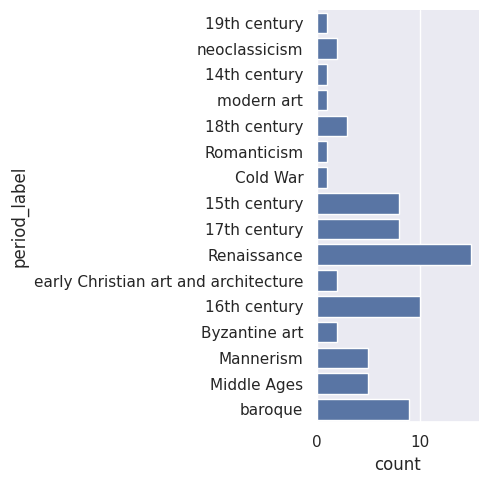

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the default theme
# sns.set_theme() in older versions of seaborn
sns.set()

# rename data frame
periods = df

# count function to show the number of observations of a category (period_label) in a dataset as a bar chart
# see documentation here https://seaborn.pydata.org/generated/seaborn.catplot.html
my_plot = sns.catplot(y="period_label", kind="count", data=periods)

The library allows us to save plots as images - possibly, to be included in a web page :)

In [8]:
my_plot.savefig("distribution.png")

## 2 Case study: what are the most studied artistic and historical periods studied over time

We want to answer the following question:

```
What are the most studied artistic and historical periods studied over time according to ARTchives?
```

This question implies us to get some **temporal** insights, when and to what extent collections reference a certain artistic period.

In order to answer this question we need to go through the seven stages of information visualization, namely:

 * acquire
 * parse
 * filter
 * mine
 * represent
 * refine
 * interact


### 2.1. Acquire, parse, and filter data

 * We leverage the same RDF dump of ARTchives data (`../resources/artchives.nq`).
 * We parse the data by using the RDFLib python library.


### 2.2 Filtering
In order to answer our research question we need to work only on a subset of the graph.

 * archival collections are annotated with the timespan of the creator's activity (earliest date `wd:Q9388534 > wdt:P1319 > ?earliest` and latest date `wd:Q9388534 > wdt:P1326 > ?latest`)

For the **temporal analysis**, we need to extract:  

 * the names of the artistic periods (values of the property `art:hasSubjectPeriod / rdfs:label`)
 * the timespans of collections (earliest `wdt:P1319` and latest `wdt:P1326`)

This is a *bivariate* analysis, looking for the distribution of a *categorial attribute* over time. The aim is to find an association between time spans and topics (artistic periods) in the dataset.

**AND NOW?** To make the analysis easier, we extract the data we need in **separate data structures** from the original one.

In order to use some popular python library for plotting data in Jupyter, we must have (again) data in **tabular form**. We want to plot our data in a **line graph**, where it's easier to see trends.

Step by step:

 * We query our the graph, looking for subject periods, collections, collections dates.
 * Rather than iterating over triples, we use a sparql query.
 * We need to take into account that some collections may not have some variables. The results of our query will include in every row a unique combination of periods, collections, and collections dates if available

In [9]:
# sparql

query_periods_dates = g.query(
    """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    SELECT (SAMPLE(?coll_label) AS ?coll) (SAMPLE(?label) AS ?period_label) ?earliest ?latest
    WHERE {?coll <https://w3id.org/artchives/hasSubjectPeriod> ?period ; rdfs:label ?coll_label .
    ?period rdfs:label ?label .
    OPTIONAL {?coll wdt:P1319 ?earliest}
    OPTIONAL {?coll wdt:P1326 ?latest}
    }
    GROUP BY ?period ?coll ?earliest ?latest
    ORDER BY ?period_label""")

### 2.2. Mine data

In order to plot periods distribution over time, we need a **time series**, meaning a **continuous** series of time observations (in our case we simplify observations to years). However, we have only time ranges (e.g. 1910-1986). We need to **expand the results** of the query with intermediate points.

 * We iterate over the results of the query (a list of tuples) and for each result (coll, period, earliest, latest) we create a new tuple (coll, period, year) where the year is a number included in the range(earliest,latest)
 * We create a python list to store the new tuples

In [10]:
# the new list
periods_dates_expanded = []

# query the list of tuples of query results
for res in query_periods_dates:
    # pruning results without dates (NB. I know all collections have dates)
    if res["earliest"] is not None and res["latest"] is not None:
        timespan = list(range( int(res["earliest"][:4]), int(res["latest"][:4])+1 ))
        for year in timespan:
            periods_dates_expanded.append( ( str(res["coll"]).strip(), str(res["period_label"]).strip(), str(year)) ) # append a tuple!

print(periods_dates_expanded)

[('Archivio Luisa Vertova', '19th century', '1960'), ('Archivio Luisa Vertova', '19th century', '1961'), ('Archivio Luisa Vertova', '19th century', '1962'), ('Archivio Luisa Vertova', '19th century', '1963'), ('Archivio Luisa Vertova', '19th century', '1964'), ('Archivio Luisa Vertova', '19th century', '1965'), ('Archivio Luisa Vertova', '19th century', '1966'), ('Archivio Luisa Vertova', '19th century', '1967'), ('Archivio Luisa Vertova', '19th century', '1968'), ('Archivio Luisa Vertova', '19th century', '1969'), ('Archivio Luisa Vertova', '19th century', '1970'), ('Archivio Luisa Vertova', '19th century', '1971'), ('Archivio Luisa Vertova', '19th century', '1972'), ('Archivio Luisa Vertova', '19th century', '1973'), ('Archivio Luisa Vertova', '19th century', '1974'), ('Archivio Luisa Vertova', '19th century', '1975'), ('Archivio Luisa Vertova', '19th century', '1976'), ('Archivio Luisa Vertova', '19th century', '1977'), ('Archivio Luisa Vertova', '19th century', '1978'), ('Archivio 

* We prepare a table (a .csv file) with three columns (`collection`, `period_label`, `year`) and we write our results of the query there.

In [11]:

# prepare the csv file
with open('periods_dates.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['collection', 'period_label', 'year'])

    # access the rows of the query results
    for coll, label, year in periods_dates_expanded:
        # write in the csv
        my_writer.writerow([coll.strip(), label.strip(), year])

 * We parse the table in a data frame

In [12]:
# parse the csv into a dataframe
data = pd.read_csv("periods_dates.csv")
# print the first 5 rows
data.head()

,collection,period_label,year
0,Archivio Luisa Vertova,19th century,1960
1,Archivio Luisa Vertova,19th century,1961
2,Archivio Luisa Vertova,19th century,1962
3,Archivio Luisa Vertova,19th century,1963
4,Archivio Luisa Vertova,19th century,1964


In order to visualize the artistic periods through the time series (x axis), and the number of collections linked to the period (y axis), we need to re-organize the dataframe.

 * we do not need the collection names
 * we need pairs period/year
 * for each pair period/year we need the number of collections in which the period appears

Pandas allows us to create new dataframes from an existing one **by grouping rows** according to values included in one or more columns.

In [13]:
# group rows by period and year, hence add a column with the counting of collections
data_by_year = data.groupby( ["period_label", "year"] ).size().reset_index()
# rename the columns
data_by_year.columns = ["period_label", "year", "count_coll"]
# see the first rows
data_by_year.head()

,period_label,year,count_coll
0,14th century,1965,1
1,14th century,1966,1
2,14th century,1967,1
3,14th century,1968,1
4,14th century,1969,1


### 1.3 Represent: Profiling and exploration, plotting data


In [14]:
# profiling
pp.ProfileReport(data_by_year)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00, 33.68it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

To make the initial exploration easier, we can create as many charts as the periods, by using **relplot** in seaborn.

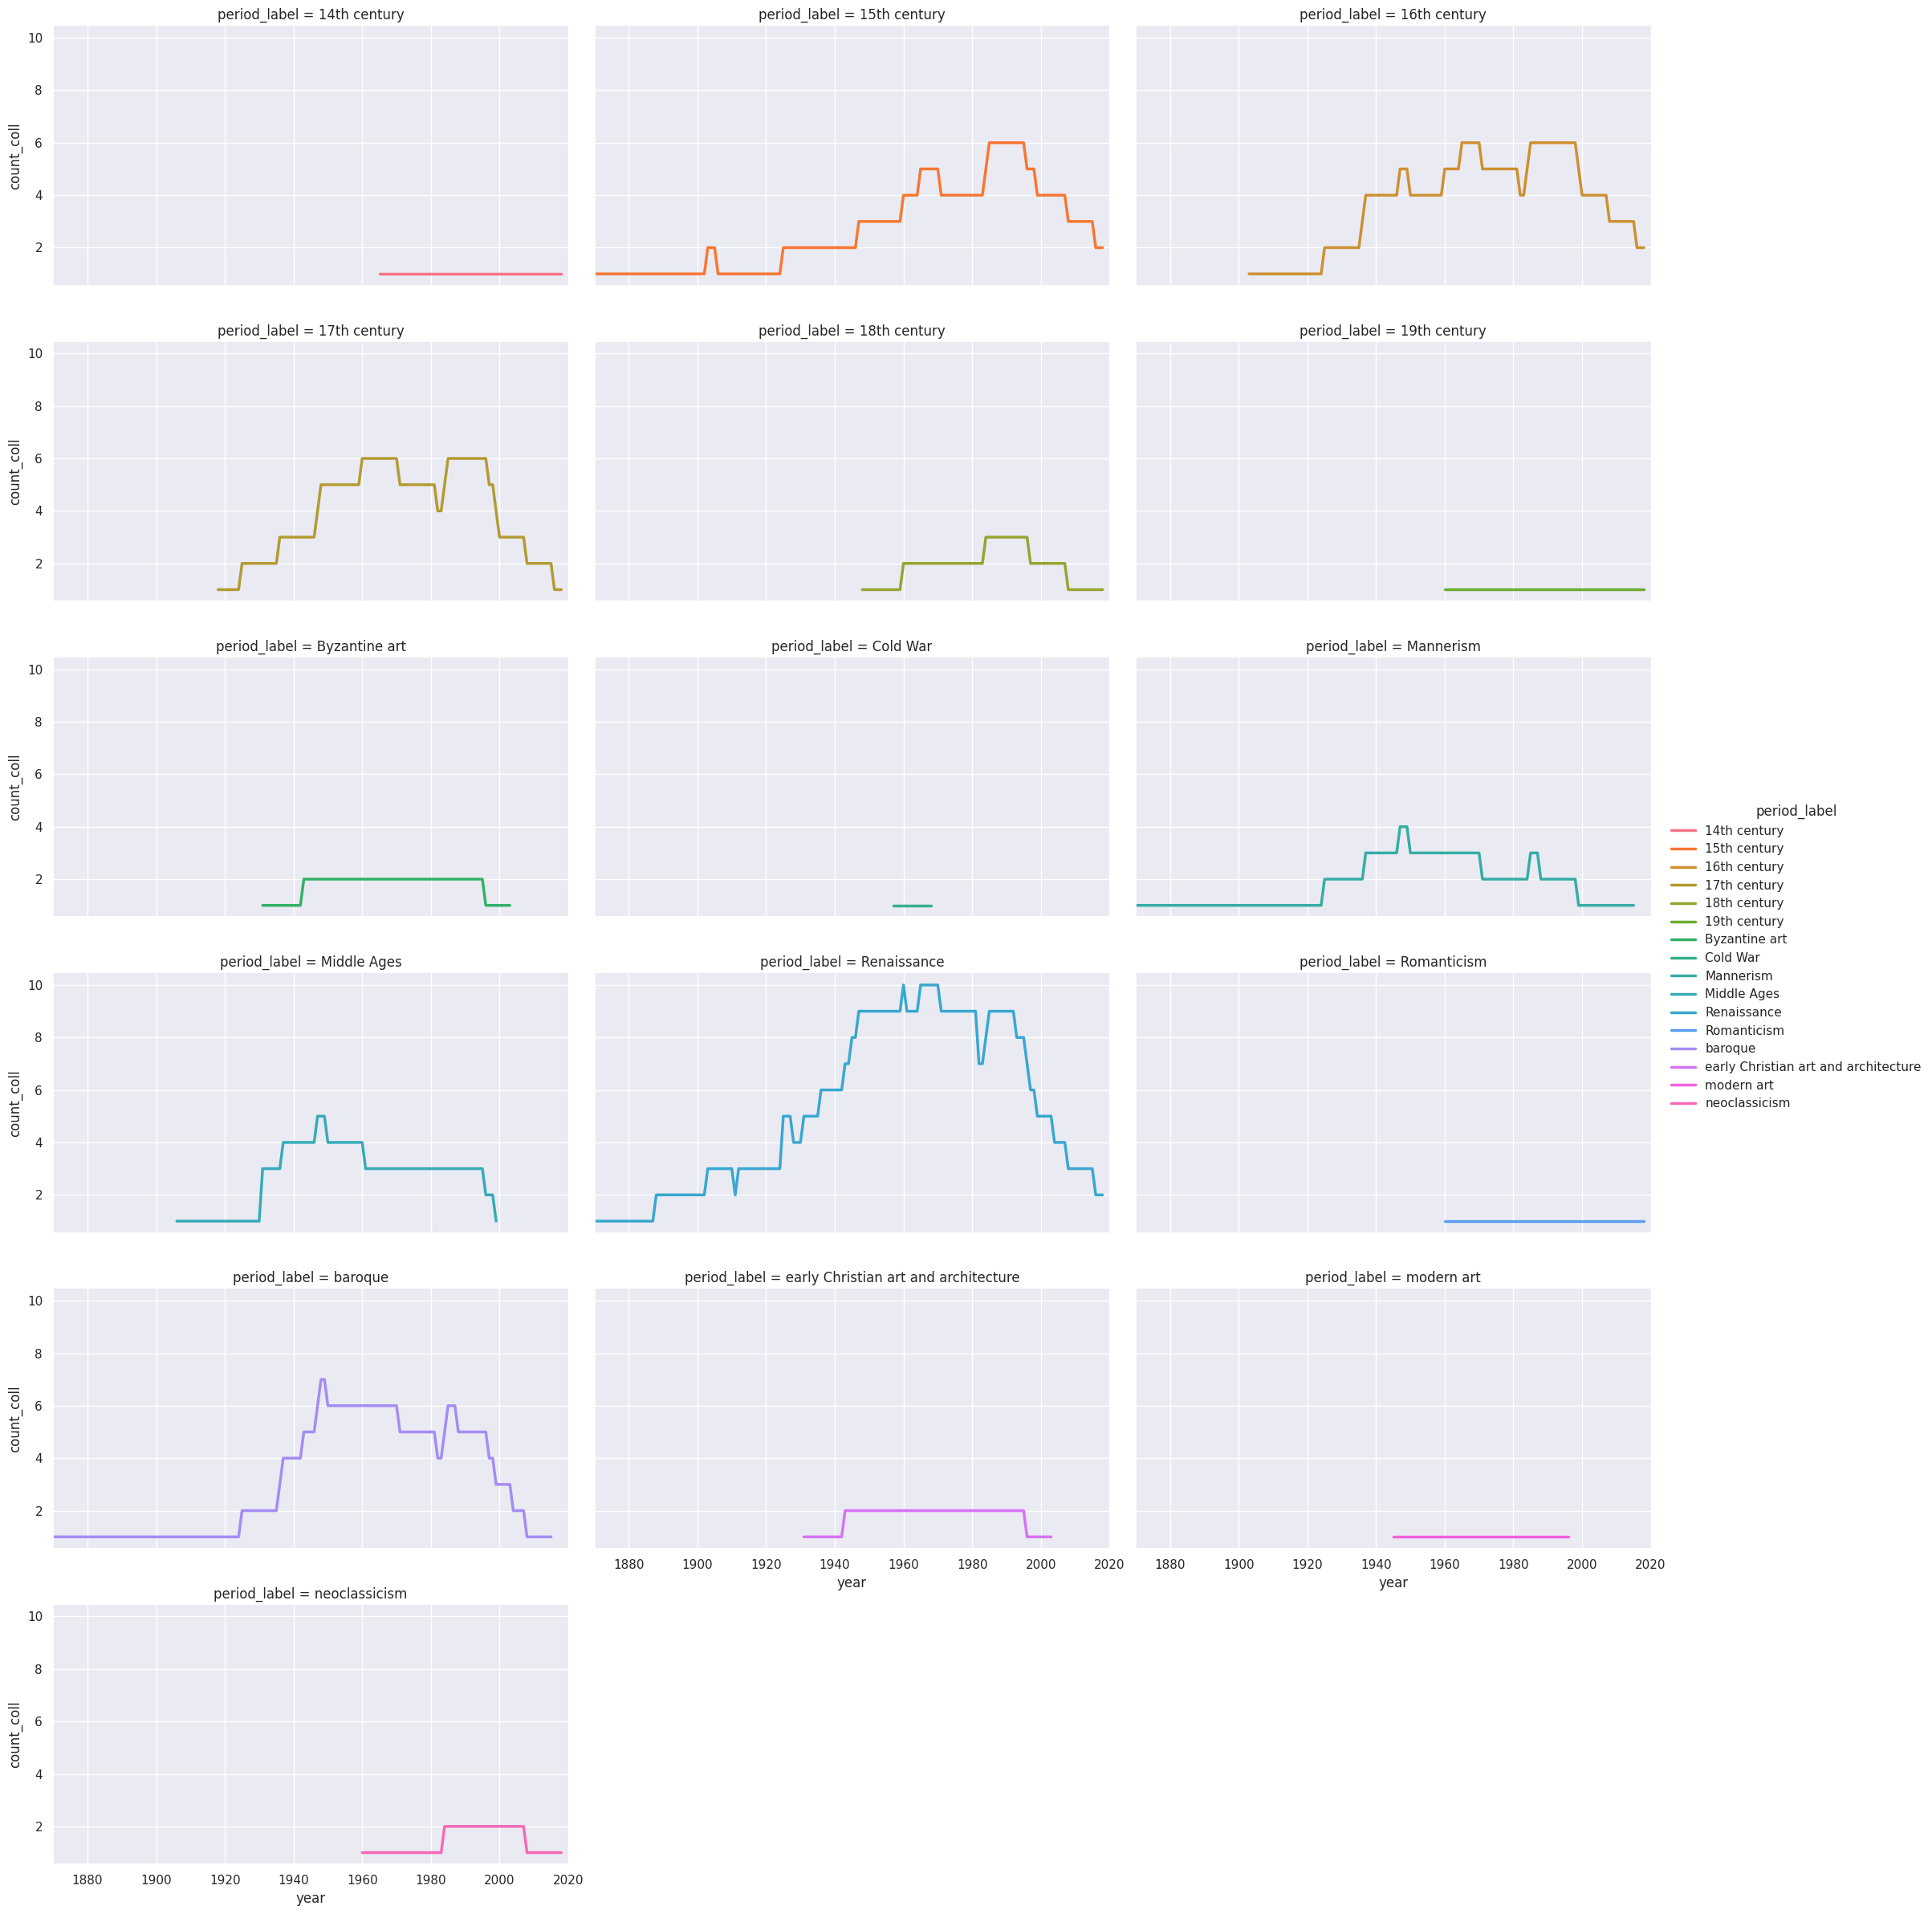

In [15]:
# plotting
# see documentation here https://seaborn.pydata.org/generated/seaborn.relplot.html
mult_plot = sns.relplot(x="year", y="count_coll", hue="period_label",
            col="period_label", col_wrap=3,
            height=4, aspect=1.75, linewidth=2.5,
            kind="line", data=data_by_year);

# reset the x origin to year 1870
mult_plot.set(xlim=(1870, 2020))

We can now compare all the periods in the same plot.

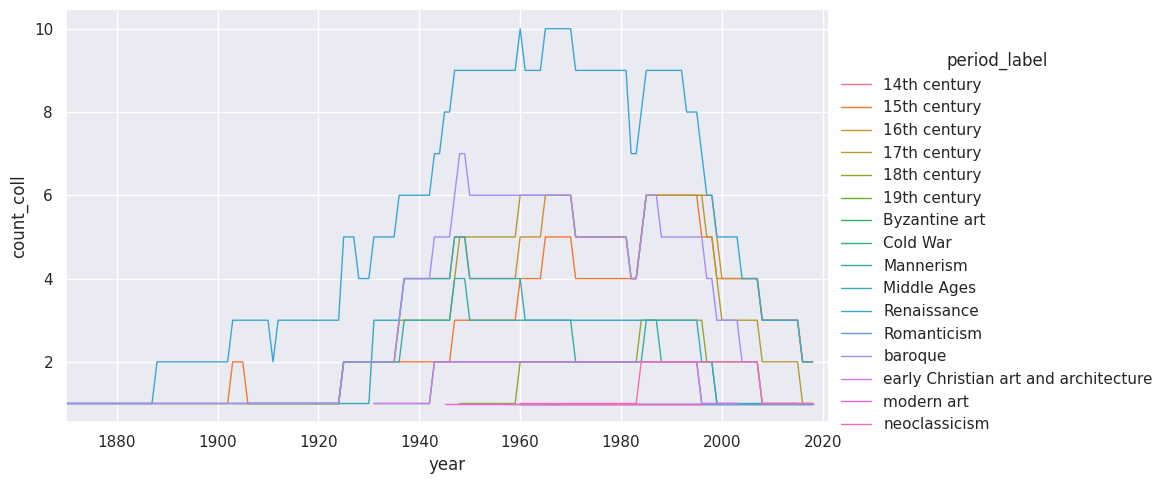

In [16]:
my_pl = sns.relplot(x="year", y="count_coll", hue="period_label",
            height=5, aspect=1.75, linewidth=1,
            kind="line", data=data_by_year);

# reset the x origin to year 1870
my_pl.set(xlim=(1870, 2021))

## In summary. How to plan your work

 * choose a research question
 * define pieces of information needed to answer the question (e.g. *What are the most studied artistic and historical periods according to ARTchives?* requires artistic periods and their counting)
 * map pieces of information to their data types (i.e. categorical, numerical)
 * choose the plot according to the data types you have and the patter you want to visualize (e.g. a bar chart to compare quantities and highlight the highest)
 * get your data (e.g. download,
 * perform a a SPARQL query to filter/ manipulate your data (select the variables that matter, make operations like countings)
 * study requirements of your data visualization library
   * what is the input data format? usually a table
   * what is the expected organisation? e.g.every row should include an artistic period and its counting
   * what data types are accepted? e.g. strings and integers
 * create a data structure that fits the plotting requirements
 * plot the result in your IDE
 * tweak the chart (add titles, labels, change colors, etc.)




## Exercise: Represent and refine

 * Visualise the distribution of periods in the dataset (case study 1) as a dot chart (look at this [tutorial](https://seaborn.pydata.org/tutorial/categorical.html#categorical-scatterplots).).
 * set the size of the plot (see this [tutorial](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034349&utm_targetid=dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=20616&gclid=Cj0KCQiAwMP9BRCzARIsAPWTJ_ETdq6AK5GBlFVxsKC9csqzAJsaOY7LirXfWLZ40ITxrglJLCQxT_oaAny_EALw_wcB#figsize))
 * rotate labels on the x axis (see this [tutorial](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034349&utm_targetid=dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=20616&gclid=Cj0KCQiAwMP9BRCzARIsAPWTJ_ETdq6AK5GBlFVxsKC9csqzAJsaOY7LirXfWLZ40ITxrglJLCQxT_oaAny_EALw_wcB#rotate))



In [17]:
# solution

#DOT Chart

In [22]:
pp.ProfileReport(data_by_year)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00, 30.67it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:

# First plot (simple catplot)
my_plot = sns.catplot(y="period_label", kind="swarm", data=periods)

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 93.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
